In [1]:
import numpy as np
import paddle
from matplotlib import pyplot as plt
from IPython import display as ipd
import soundfile as sf
import librosa.display
from parakeet.utils import display
paddle.set_device("gpu:0")
import sys
sys.path.append("../../")

In [2]:
%matplotlib inline

## 加载模型

In [3]:
from examples.ge2e.audio_processor import SpeakerVerificationPreprocessor
from parakeet.models.lstm_speaker_encoder import LSTMSpeakerEncoder

# speaker encoder
p = SpeakerVerificationPreprocessor(
    sampling_rate=16000, 
    audio_norm_target_dBFS=-30, 
    vad_window_length=30, 
    vad_moving_average_width=8, 
    vad_max_silence_length=6, 
    mel_window_length=25, 
    mel_window_step=10, 
    n_mels=40, 
    partial_n_frames=160, 
    min_pad_coverage=0.75, 
    partial_overlap_ratio=0.5)
speaker_encoder = LSTMSpeakerEncoder(n_mels=40, num_layers=3, hidden_size=256, output_size=256)
speaker_encoder_params_path = "../../pretrained/ge2e/ge2e_ckpt_0.3/step-3000000.pdparams"
speaker_encoder.set_state_dict(paddle.load(speaker_encoder_params_path))
speaker_encoder.eval()

# synthesizer
from parakeet.models.tacotron2 import Tacotron2
from examples.tacotron2_aishell3.chinese_g2p import convert_sentence
from examples.tacotron2_aishell3.aishell3 import voc_phones, voc_tones

synthesizer = Tacotron2(
    vocab_size=68,
    n_tones=10,
    d_mels= 80,
    d_encoder= 512,
    encoder_conv_layers = 3,
    encoder_kernel_size= 5,
    d_prenet= 256,
    d_attention_rnn= 1024,
    d_decoder_rnn = 1024,
    attention_filters = 32,
    attention_kernel_size = 31,
    d_attention= 128,
    d_postnet = 512,
    postnet_kernel_size = 5,
    postnet_conv_layers = 5,
    reduction_factor = 1,
    p_encoder_dropout = 0.5,
    p_prenet_dropout= 0.5,
    p_attention_dropout= 0.1,
    p_decoder_dropout= 0.1,
    p_postnet_dropout= 0.5,
    d_global_condition=256,
    use_stop_token=False,
)
params_path = "../../pretrained/tacotron2_aishell3/tacotron2_aishell3_ckpt_0.3/step-450000.pdparams"
synthesizer.set_state_dict(paddle.load(params_path))
synthesizer.eval()

# vocoder
from parakeet.models import ConditionalWaveFlow
vocoder = ConditionalWaveFlow(upsample_factors=[16, 16], n_flows=8, n_layers=8, n_group=16, channels=128, n_mels=80, kernel_size=[3, 3])
params_path = "../../pretrained/waveflow/waveflow_ljspeech_ckpt_0.3/step-2000000.pdparams"
vocoder.set_state_dict(paddle.load(params_path))
vocoder.eval()

vocab_phones:
 Vocab(size: 68,
stoi:
OrderedDict([('<pad>', 0), ('<unk>', 1), ('<s>', 2), ('</s>', 3), ('$', 4), ('%', 5), ('&r', 6), ('a', 7), ('ai', 8), ('an', 9), ('ang', 10), ('ao', 11), ('b', 12), ('c', 13), ('ch', 14), ('d', 15), ('e', 16), ('ea', 17), ('ei', 18), ('en', 19), ('eng', 20), ('er', 21), ('f', 22), ('g', 23), ('h', 24), ('i', 25), ('ia', 26), ('iai', 27), ('ian', 28), ('iang', 29), ('iao', 30), ('ie', 31), ('ien', 32), ('ieng', 33), ('ii', 34), ('iii', 35), ('io', 36), ('iou', 37), ('j', 38), ('k', 39), ('l', 40), ('m', 41), ('n', 42), ('o', 43), ('ou', 44), ('p', 45), ('q', 46), ('r', 47), ('s', 48), ('sh', 49), ('t', 50), ('u', 51), ('ua', 52), ('uai', 53), ('uan', 54), ('uang', 55), ('uei', 56), ('uen', 57), ('ueng', 58), ('uo', 59), ('v', 60), ('van', 61), ('ve', 62), ('ven', 63), ('veng', 64), ('x', 65), ('z', 66), ('zh', 67)]))
vocab_tones:
 Vocab(size: 10,
stoi:
OrderedDict([('<pad>', 0), ('<unk>', 1), ('<s>', 2), ('</s>', 3), ('0', 4), ('1', 5), ('2', 6), ('3

## 生成 speaker encoding

首先在当前文件夹下新建文件夹 `ref_audio`，把要作为参考的音频存在在这个文件夹中。格式要求是 wav 格式，采样率会被重采样至 16kHz.

In [4]:
ref_name = "女声2.wav"
ref_audio_path = f"./ref_audio/{ref_name}"
ipd.Audio(ref_audio_path, normalize=True)

In [5]:
mel_sequences = p.extract_mel_partials(p.preprocess_wav(ref_audio_path))
print("mel_sequences: ", mel_sequences.shape)
with paddle.no_grad():
    embed = speaker_encoder.embed_utterance(paddle.to_tensor(mel_sequences))
print("embed shape: ", embed.shape)

mel_sequences:  (2, 160, 40)
embed shape:  [256]


## 合成频谱

因为 AISHELL-3 数据集中使用 `%` 和 `$` 表示韵律词和韵律短语的边界，它们大约对应着较短和较长的停顿，在文本中可以使用 `%` 和 `$` 来调节韵律。

值得的注意的是，句子的有效字符集仅包含汉字和 `%`, `$`, 因此输入的句子只能包含这些字符。

In [6]:
sentence = "每当你觉得%想要批评什么人的时候$你切要记着%这个世界上的人%并非都具备你禀有的条件$"
phones, tones = convert_sentence(sentence)
print(phones)
print(tones)

phones = np.array([voc_phones.lookup(item) for item in phones], dtype=np.int64)
tones = np.array([voc_tones.lookup(item) for item in tones], dtype=np.int64)

phones = paddle.to_tensor(phones).unsqueeze(0)
tones = paddle.to_tensor(tones).unsqueeze(0)
utterance_embeds = paddle.unsqueeze(embed, 0)

['m', 'ei', 'd', 'ang', 'n', 'i', 'j', 've', 'd', 'e', '%', 'x', 'iang', 'iao', 'p', 'i', 'p', 'ieng', 'sh', 'en', 'm', 'e', 'r', 'en', 'd', 'e', 'sh', 'iii', 'h', 'ou', '$', 'n', 'i', 'q', 'ie', 'iao', 'j', 'i', 'zh', 'e', '%', 'zh', 'e', 'g', 'e', 'sh', 'iii', 'j', 'ie', 'sh', 'ang', 'd', 'e', 'r', 'en', '%', 'b', 'ieng', 'f', 'ei', 'd', 'ou', 'j', 'v', 'b', 'ei', 'n', 'i', 'b', 'ieng', 'iou', 'd', 'e', 't', 'iao', 'j', 'ian', '$']
['0', '3', '0', '1', '0', '3', '0', '2', '0', '5', '0', '0', '3', '4', '0', '1', '0', '2', '0', '2', '0', '5', '0', '2', '0', '5', '0', '2', '0', '4', '0', '0', '3', '0', '4', '4', '0', '4', '0', '5', '0', '0', '4', '0', '4', '0', '4', '0', '4', '0', '4', '0', '5', '0', '2', '0', '0', '4', '0', '1', '0', '1', '0', '4', '0', '4', '0', '3', '0', '3', '3', '0', '5', '0', '2', '0', '4', '0']


 73%|███████▎  | 733/1000 [00:02<00:01, 255.71it/s]


content exhausted!


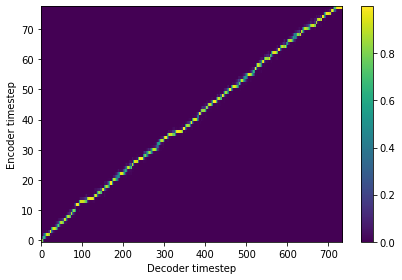

In [7]:
outputs = synthesizer.infer(phones, tones=tones, global_condition=utterance_embeds)
mel_input = paddle.transpose(outputs["mel_outputs_postnet"], [0, 2, 1])
fig = display.plot_alignment(outputs["alignments"][0].numpy().T)

## 合成语音

合成的语音会保存在 `syn_audio` 目录下，使用和 reference 相同的文件名。

time: 19.793312788009644s


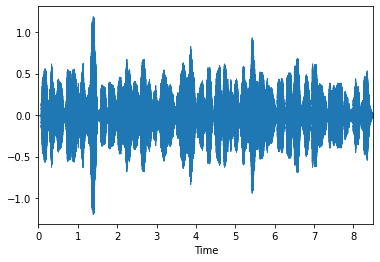

In [8]:
with paddle.no_grad():
    wav = vocoder.infer(mel_input)
wav = wav.numpy()[0]
sf.write(f"syn_audio/{ref_name}", wav, samplerate=22050)
librosa.display.waveplot(wav)

In [9]:
ipd.Audio(wav, rate=22050)